# 1. Importing libraries and loading Data

### 1.1 Installing necessary libraries


In [ ]:
"""
%pip install nltk
%pip install emoji
%pip install tensorflow
%pip install transformers
%pip install pandas
%pip install numpy
%pip install sklearn
%pip install matplotlib
%pip install seaborn
"""


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import emoji
import re
import string
from fast_bert.data_cls import BertDataBunch
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
import tensorflow_hub as hub

# Packages to define a BERT model
from transformers import TFBertModel, BertTokenizerFast, BertConfig

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K
from keras.layers import Input, Dropout, Dense
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.initializers import TruncatedNormal


### 1.2 Plot Defaults


In [2]:
# sns.set(font='sans-serif',
#         rc={
#             'axes.axisbelow': False,
#             'axes.edgecolor': 'lightgrey',
#             'axes.facecolor': 'None',
#             'axes.grid': False,
#             'axes.spines.right': False,
#             'axes.spines.top': False,
#             'figure.facecolor': 'white',
#             'lines.solid_capstyle': 'round',
#             'patch.edgecolor': 'w',
#             'patch.force_edgecolor': True,
#             'xtick.bottom': False,
#             'xtick.direction': 'out',
#             'xtick.top': False,
#             'ytick.direction': 'out',
#             'ytick.left': False,
#             'ytick.right': False})
            
# sns.set_context('notebook', rc={'font.size': 14,
#                                 'axes.titlesize': 14,
#                                 'axes.labelsize': 14})

colors = sns.color_palette('rocket_r')
sns.set_palette('rocket_r')


### 1.3 Helper Functions

In [88]:
def idx2class(idx_list):
    """
    This function converts a list of class indices to a list of class labels.

    Parameters
    ----------
    idx_list : list
        List of class indices.
    
    Returns
    -------
    class_list : list
        List of class labels.
    """
    arr = []
    for i in idx_list:
        arr.append(labels[int(i)])
    return arr

def EmotionMapping(list_of_emotions):
    list = []  
    for i in list_of_emotions:
        if i in ekman_map['anger']:
            list.append('anger')
        if i in ekman_map['disgust']:
            list.append('disgust')
        if i in ekman_map['fear']:
            list.append('fear')
        if i in ekman_map['joy']:
            list.append('joy')
        if i in ekman_map['sadness']:
            list.append('sadness')
        if i in ekman_map['surprise']:
            list.append('surprise')
        if i == 'neutral':
            list.append('neutral')      
    return list

def SentimentMapping(list_of_emotions):
    list = []  
    for i in list_of_emotions:
        if i in sentiment_map['positive']:
            list.append('positive')
        if i in sentiment_map['negative']:
            list.append('negative')
        if i in sentiment_map['ambiguous']:
            list.append('ambiguous')
    return list

### 1.4 Loading data

In [89]:
train_url = 'https://github.com/google-research/google-research/raw/master/goemotions/data/train.tsv'
valid_url = 'https://github.com/google-research/google-research/raw/master/goemotions/data/dev.tsv'
test_url = 'https://github.com/google-research/google-research/raw/master/goemotions/data/test.tsv'

In [90]:
train_df = pd.read_csv(train_url, sep='\t', encoding='utf-8',
                       names=['text', 'emotion', 'annotator'], header=None)
valid_df = pd.read_csv(valid_url, sep='\t', encoding='utf-8',
                       names=['text', 'emotion', 'annotator'], header=None)
test_df = pd.read_csv(test_url, sep='\t', encoding='utf-8',
                      names=['text', 'emotion', 'annotator'], header=None)

In [91]:
train_df.head(2)

,text,emotion,annotator
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i


In [92]:
train_df

,text,emotion,annotator
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj
...,...,...,...
43405,Added you mate well I’ve just got the bow and ...,18,edsb738
43406,Always thought that was funny but is it a refe...,6,ee7fdou
43407,What are you talking about? Anything bad that ...,3,efgbhks
43408,"More like a baptism, with sexy results!",13,ed1naf8


### 1.5 Preprocessing

Column 2 "annotator" is unnecessary, so we can drop it.


In [93]:
train_df.drop('annotator', axis=1, inplace=True)
valid_df.drop('annotator', axis=1, inplace=True)
test_df.drop('annotator', axis=1, inplace=True)

Dictionaries for mapping emotions to indices and vice versa. 

The variable `ekman_map` is used to map 27 emotions to 7 emotions. This is done to reduce the number of classes and still retain the same emotions in the dataset.

The 27 emotions can also be mapped to the 3 emotions using the `sentiment_map` dictionary for sentiment analysis tasks.


In [94]:
labels = {
    0: 'admiration',
    1: 'amusement',
    2: 'anger',
    3: 'annoyance',
    4: 'approval',
    5: 'caring',
    6: 'confusion',
    7: 'curiosity',
    8: 'desire',
    9: 'disappointment',
    10: 'disapproval',
    11: 'disgust',
    12: 'embarrassment',
    13: 'excitement',
    14: 'fear',
    15: 'gratitude',
    16: 'grief',
    17: 'joy',
    18: 'love',
    19: 'nervousness',
    20: 'optimism',
    21: 'pride',
    22: 'realization',
    23: 'relief',
    24: 'remorse',
    25: 'sadness',
    26: 'surprise',
    27: 'neutral'
}

ekman_map = {
    'anger': ['anger', 'annoyance', 'disapproval'],
    'disgust': ['disgust'],
    'fear': ['fear', 'nervousness'],
    'joy': ['joy', 'amusement', 'approval', 'excitement', 'gratitude',  'love', 'optimism', 'relief', 'pride', 'admiration', 'desire', 'caring'],
    'sadness': ['sadness', 'disappointment', 'embarrassment', 'grief',  'remorse'],
    'surprise': ['surprise', 'realization', 'confusion', 'curiosity'],
    'neutral': ['neutral']
}

sentiment_map = {
    "positive": ["amusement", "excitement", "joy", "love", "desire", "optimism", "caring", "pride", "admiration", "gratitude", "relief", "approval"],
    "negative": ["fear", "nervousness", "remorse", "embarrassment", "disappointment", "sadness", "grief", "disgust", "anger", "annoyance", "disapproval"],
    "ambiguous": ["realization", "surprise", "curiosity", "confusion", "neutral"]
}

First, let's extract all emotions from the each example and store them in a list.

In [95]:
train_df['list of emotions'] = train_df['emotion'].apply(lambda x: x.split(','))
test_df['list of emotions'] = test_df['emotion'].apply(lambda x: x.split(','))
valid_df['list of emotions'] = valid_df['emotion'].apply(lambda x: x.split(','))

We can then apply index to class mapping to get the class labels for each row

In [96]:
train_df['emotion'] = train_df['list of emotions'].apply(lambda x: idx2class(x))
test_df['emotion'] = test_df['list of emotions'].apply(lambda x: idx2class(x))
valid_df['emotion'] = valid_df['list of emotions'].apply(lambda x: idx2class(x))

Finally, we can reduce the number of classes to 7 by using the EmotionMapping function.

In [97]:
train_df['ekman_emotion'] = train_df['emotion'].apply(lambda x: EmotionMapping(x))
test_df['ekman_emotion'] = test_df['emotion'].apply(lambda x: EmotionMapping(x))
valid_df['ekman_emotion'] = valid_df['emotion'].apply(lambda x: EmotionMapping(x))

In [98]:
train_df.head(10)

,text,emotion,list of emotions,ekman_emotion
0,My favourite food is anything I didn't have to...,[neutral],[27],[neutral]
1,"Now if he does off himself, everyone will thin...",[neutral],[27],[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,[anger],[2],[anger]
3,To make her feel threatened,[fear],[14],[fear]
4,Dirty Southern Wankers,[annoyance],[3],[anger]
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,[surprise],[26],[surprise]
6,Yes I heard abt the f bombs! That has to be wh...,[gratitude],[15],[joy]
7,We need more boards and to create a bit more s...,"[desire, optimism]","[8, 20]","[joy, joy]"
8,Damn youtube and outrage drama is super lucrat...,[admiration],[0],[joy]
9,It might be linked to the trust factor of your...,[neutral],[27],[neutral]


In [99]:
def clean_text(text):
    """
    This function cleans the text in the dataframe and returns a list of cleaned text.
    text: a string

    return: modified initial string
    """
    # Removing Emojis
    text = emoji.demojize(text)  # remove emojis
    text = str(text).lower()  # text to lower case
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)  # remove punctuation
    return text

One hot encoding of emotions 

In [100]:
for i in ekman_map:
    train_df[i] = train_df['ekman_emotion'].apply(lambda x: 1 if i in x else 0)
    test_df[i] = test_df['ekman_emotion'].apply(lambda x: 1 if i in x else 0)
    valid_df[i] = valid_df['ekman_emotion'].apply(lambda x: 1 if i in x else 0)

In [101]:
train_df.head(10)

,text,emotion,list of emotions,ekman_emotion,anger,disgust,fear,joy,sadness,surprise,neutral
0,My favourite food is anything I didn't have to...,[neutral],[27],[neutral],0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",[neutral],[27],[neutral],0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,[anger],[2],[anger],1,0,0,0,0,0,0
3,To make her feel threatened,[fear],[14],[fear],0,0,1,0,0,0,0
4,Dirty Southern Wankers,[annoyance],[3],[anger],1,0,0,0,0,0,0
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,[surprise],[26],[surprise],0,0,0,0,0,1,0
6,Yes I heard abt the f bombs! That has to be wh...,[gratitude],[15],[joy],0,0,0,1,0,0,0
7,We need more boards and to create a bit more s...,"[desire, optimism]","[8, 20]","[joy, joy]",0,0,0,1,0,0,0
8,Damn youtube and outrage drama is super lucrat...,[admiration],[0],[joy],0,0,0,1,0,0,0
9,It might be linked to the trust factor of your...,[neutral],[27],[neutral],0,0,0,0,0,0,1


### 1.6 Visualization

Bar plot of distribution of emotions

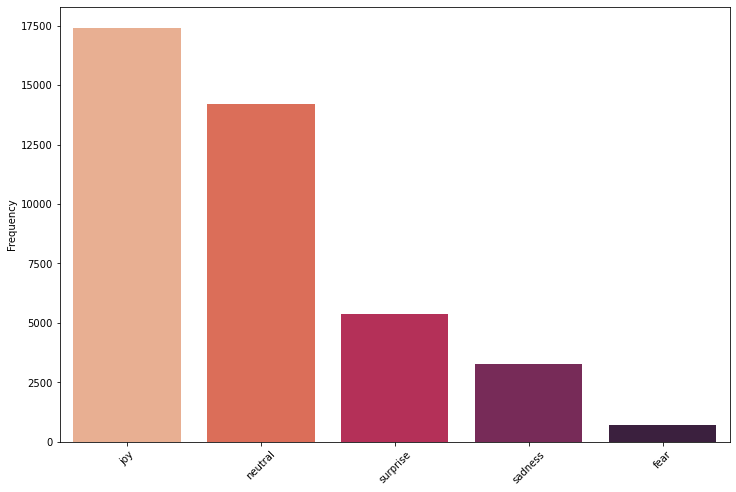

In [102]:
labels_summary = train_df.iloc[:, 6:].sum()
labels_summary.sort_values(ascending=False, inplace=True)

fig = plt.figure(figsize=(12, 8))
sns.barplot(x=labels_summary.index,
            y=labels_summary.values, palette='rocket_r')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.show()

Distribution of text length in the train set

<Figure size 864x720 with 0 Axes>

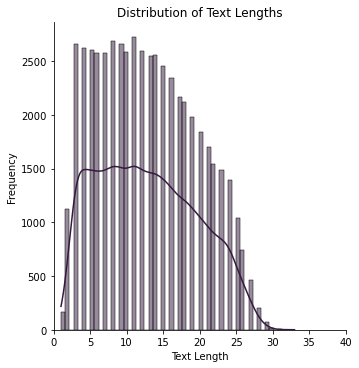

In [116]:
full_text = pd.concat([train_df['text'], valid_df['text'], test_df['text']])
lengths = full_text.apply(lambda x: len(x.split()))
fig = plt.figure(figsize=(12, 10))
sns.displot(lengths, kde=True, rug=False, color=colors[5])
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.xlim(0, 40)
plt.show()

# 2. Model

### 2.1 Base model config

#### Computing max length of samples

`max_length` variable is used to limit the length of the input text that is fed to the model. The sequence will be padded with the `<PAD>` token if the length of the sequence is less than `max_length` and the sequence will be truncated if the length of the sequence is more than `max_length`. This is done to ensure that the model can handle any size of input text.

In [130]:
full_text = pd.concat([train_df['text'], valid_df['text'], test_df['text']])
max_length = full_text.apply(lambda x: len(x.split())).max()
max_length

33

I am going to use Google's BERT base model which contains 110M parameters.

In [131]:
model_name = 'bert-base-uncased'
config = BertConfig.from_pretrained(model_name, output_hidden_states=False)
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


### 2.2 Model architecture

model takes three inputs that result from tokenization:

- `input_ids`: indices of input sequence tokens in the vocabulary
- `token_type_ids`: Segment token indices to indicate first and second portions of the inputs. 0 for sentence A and 1 for sentence B
- `attention mask`: Mask to avoid performing attention on padding token indices. 0 for masked and 1 for not masked

We have a sigmoided output layer in the model because it is more appropriate than a softmax layer.
  This is because we are trying to predict the probability of each label and not the label itself.


In [134]:
def my_model(n_labels):

  # Load the MainLayer
  bert = transformer_model.layers[0]

  ## INPUTS
  input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
  attention_mask = Input(shape=(max_length,), name='attention_mask', dtype='int32')
  token_type_ids = Input(shape=(max_length,), name='token_type_ids', dtype='int32')
  inputs = {'input_ids': input_ids, 'attention_mask': attention_mask, 'token_type_ids': token_type_ids}

  ## LAYERS
  bert_model = bert(inputs)[1]
  dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
  pooled_output = dropout(bert_model, training=False)

  ## OUTPUT
  emotion = Dense(units=n_labels, activation='sigmoid', kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='emotion')(pooled_output)
  outputs = emotion

  model = Model(inputs=inputs, outputs=outputs, name='BERT_Emotion_Classifier')

  return model

In [136]:
model = my_model(len(ekman_map))
model.summary()

Model: "BERT_Emotion_Classifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 33)]         0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 33)]         0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 33)]         0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['attention_mask[0][0]',         
                                thPoolingAndCrossAt               'input_ids

In [142]:
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
